# Part 2: Minimizing boolean terms using a less naive method
We will generate a bunch of boolean terms (in the signature containing just `not`, `and`, `or`, `0` and `1`) and try to minimize them using basic equational laws of boolean algebra. We will use an approach which consists in repeatedly applying one layer of the naive breadth-first method (discussed in the previous notebook) with subsequent extraction of the minimal term. Each naive phase will be limited to 200 steps, and we also do no more than one layer, so tracking new matches is disabled for efficiency.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import os
import tqdm
from matplotlib import pyplot as plt

In [2]:
import sys
sys.path.append("../")

import peqsen
import peqsen.examples.term_minimization
peqsen.examples.term_minimization.tqdm_impl = tqdm.tqdm_notebook
from peqsen.examples.term_minimization import *

### Configuration

In [23]:
dirname = "temp-boolean-terms-minimization-02"
os.makedirs(dirname, exist_ok=True)

# The number of parallel processes
n_jobs = 2

max_size = 100
min_size = 10
# Generate 5 terms for each term size
count_per_size = 5
# The maximum number of free variables in each term
variables_num = 3

Let's start with generating some boolean terms. We take them from some distribution which is designed to generate terms of a given size, however it's NOT some well thought-out distribution with nice properties (it prefers balanced trees more than the uniform distribution, for example). In the future we might try some other distributions, but this will do for now.

In [24]:
db = MinimizedTermDB(dirname + "/boolean-terms.db")
if db.empty():
    generate_random_terms_db(db, BooleanSig.signature, n_jobs=n_jobs, 
                             min_size=min_size, max_size=max_size, count_per_size=count_per_size,
                             variables=variables_num)

Let's make sure that samples look more or less sane.

In [25]:
for mt in itertools.islice(db.values(), 3):
    print(peqsen.term_size(mt.original), mt.original)

10 and(and(or($2(), 1()), not(0())), or($1(), 0()))
10 not(not(or(or(not($1()), $0()), and($0(), 0()))))
10 and(not(not(and($1(), $0()))), or($0(), not($0())))


## Minimization 
We will use the strategy described above, the maximum number of steps on each phase is 200, the number of phases is 5. Note that rules are applied in random order to make this procedure more fair towards rules (and this randomization also produces better results). 

In [26]:
db_repeatedly_minimized = \
    MinimizedTermDB(dirname + "/boolean-terms-repeatedly-naively-minimized-shuffle.db")
if db_repeatedly_minimized.empty():
    method = OneLayerMinimizationMethod(theory=BooleanTheory, max_steps=200)
    method = RepeatedMinimizationMethod(method=method, iterations=5)
    minimize_terms_db(db_repeatedly_minimized, method, db.values(), n_jobs=n_jobs)

Every minimized term comes with the minimized term itself and a minimization script which contains rule application 
steps necessary to reproduce the minimization.

Let's check out several samples.

In [27]:
for mt in itertools.islice(db_repeatedly_minimized.values(), 10):
    print("old size", term_size(mt.original), "new size", term_size(mt.minimized),
          "script length", script_length(mt.script))

old size 10 new size 1 script length 7
old size 10 new size 4 script length 3
old size 10 new size 3 script length 3
old size 11 new size 4 script length 8
old size 10 new size 3 script length 5
old size 10 new size 1 script length 7
old size 11 new size 1 script length 5
old size 12 new size 1 script length 4
old size 11 new size 1 script length 8
old size 11 new size 1 script length 7


Now let's draw some graphs. 

In [28]:
# Load the db into a list
list_naively_minimized = list(tqdm_impl(db_repeatedly_minimized.values()))

In [29]:
# Create a list of tuples containing interesting information
size_len_pairs = [(term_size(mt.original), term_size(mt.minimized), script_length(mt.script)) 
                  for mt in tqdm_impl(list_naively_minimized)]

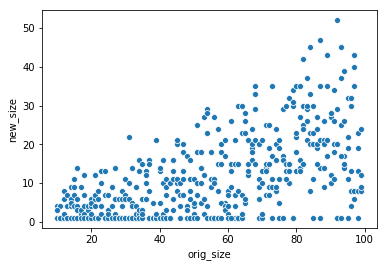

In [30]:
size_len_pairs_df = pd.DataFrame.from_records(size_len_pairs, 
                                              columns=["orig_size", "new_size", "script_len"])
sns.scatterplot(x="orig_size", y="new_size", data=size_len_pairs_df)

(From now on the descriptions are under the pictures). Each circle in this graph is a term, the horizontal coordinate is its original size, the vertical coordinate is the size of the corresponding naively minimized term. You can see that a lot of terms get reduced to size 1 (constants and single variables).

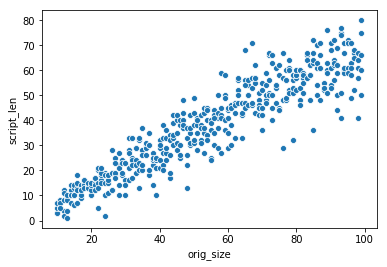

In [31]:
sns.scatterplot(x="orig_size", y="script_len", data=size_len_pairs_df)

This is the graph of the resulting script size given the original term size.

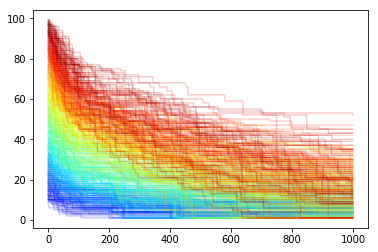

In [32]:
for mt in tqdm_impl(list_naively_minimized):
    y0 = mt.stats['substats'][0]['min_size_dynamics'][0][1]
    ys = [t[1] for s in mt.stats['substats'] for t in s['min_size_dynamics']]
    #ys = [y0] + [s['min_size_dynamics'][-1][1] for s in mt.stats['substats']]
    xs = range(len(ys))
    c = plt.get_cmap('jet')(y0/max_size)
    plt.plot(xs, ys, alpha=0.2, c=c)

This is a bunch of "minimization curves": the size of the current minimal term given the current step. The color encodes the size of the initial term.

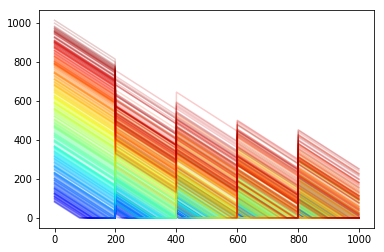

In [13]:
for mt in tqdm_impl(list_naively_minimized):
    y0 = mt.stats['substats'][0]['min_size_dynamics'][0][1]
    ys = [t[1] for s in mt.stats['substats'] for t in s['pending_matches_dynamics']]
    #ys = [y0] + [s['min_size_dynamics'][-1][1] for s in mt.stats['substats']]
    xs = range(len(ys))
    c = plt.get_cmap('jet')(y0/max_size)
    plt.plot(xs, ys, alpha=0.2, c=c)

These curves show the number of pending matches (potential rule applications, in other words) depending on the current step. You can see phase boundaries every 200 steps. Note that for most of the terms 200 steps is not enough to perform all potential rule applications within a layer.

Now let's see what rules turn out to be useful.

In [14]:
rule_stat = {}

for mt in tqdm_impl(list_naively_minimized):
    for s in collect_script_nodes(mt.script, RuleApplicationScript):
        rule_stat[s.rule.name] = rule_stat.get(s.rule.name, 0) + 1

The following list is a list of rules with the correpsonding number of applications in the final minimization scripts (which may be considered as a measure of rule usefulness). Most useful are congruence "rules", but they are not exactly rules because they are applied automatically. **Note that rules marked with `(rev)` are applied right to left!** Interestingly, many "reverse" rules are more popular than their forward counterparts (although the forward direction is usually the simplifying direction).

In [15]:
pd.DataFrame.from_dict(rule_stat, orient='index').sort_values(0, ascending=False)

,0
congruence(not),8512
congruence(0),4378
congruence(1),4351
congruence($1),4236
congruence($2),4150
congruence($0),4093
congruence(and),2090
congruence(or),2026
"and(moboh34, bikib35) = and(bikib35, moboh34)",1722
"(rev)and(moboh34, bikib35) = and(bikib35, moboh34)",1670
